# Step 1: Download dataset

In [1]:
!pip install -q --upgrade gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!gdown --id ""

In [3]:
!jar xf "MRNet-v1.0.zip"

# Step 2: Install Dependencies

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from datetime import datetime
from pathlib import Path
from sklearn import metrics
from tqdm import tqdm
from torch.autograd import Variable
from torchvision import models

# Step 3: Dataset and DataLoader

In [5]:
class MRDataset(data.Dataset):

    INPUT_DIM = 224
    MAX_PIXEL_VAL = 255
    MEAN = 58.09
    STDDEV = 49.73

    def __init__(self, datadir, tear_type, use_gpu):
        super().__init__()
        self.use_gpu = use_gpu

        label_dict = {}
        self.paths = []
        abnormal_label_dict = {}
        
        if datadir[-1]=="/":
            datadir = datadir[:-1]
        self.datadir = datadir

        for i, line in enumerate(open(datadir+'-'+tear_type+'.csv').readlines()):
            line = line.strip().split(',')
            filename = line[0]
            label = line[1]
            label_dict[filename] = int(label)

        for i, line in enumerate(open(datadir+'-'+"abnormal"+'.csv').readlines()):
            line = line.strip().split(',')
            filename = line[0]
            label = line[1]
            abnormal_label_dict[filename] = int(label)

        for filename in os.listdir(os.path.join(datadir, "axial")):
            if filename.endswith(".npy"):
                self.paths.append(filename)
        
        self.labels = [label_dict[path.split(".")[0]] for path in self.paths]
        self.abnormal_labels = [abnormal_label_dict[path.split(".")[0]] for path in self.paths]

        if tear_type != "abnormal":
            temp_labels = [self.labels[i] for i in range(len(self.labels)) if self.abnormal_labels[i]==1]
            neg_weight = np.mean(temp_labels)
        else:
            neg_weight = np.mean(self.labels)
        
        self.weights = [neg_weight, 1 - neg_weight]

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    def __getitem__(self, index):
        filename = self.paths[index]
        vol_axial = np.load(os.path.join(self.datadir, "axial", filename))
        vol_sagit = np.load(os.path.join(self.datadir, "sagittal", filename))
        vol_coron = np.load(os.path.join(self.datadir, "coronal", filename))

        # axial
        pad = int((vol_axial.shape[2] - MRDataset.INPUT_DIM)/2)
        vol_axial = vol_axial[:,pad:-pad,pad:-pad]
        vol_axial = (vol_axial-np.min(vol_axial))/(np.max(vol_axial)-np.min(vol_axial))*MRDataset.MAX_PIXEL_VAL
        vol_axial = (vol_axial - MRDataset.MEAN) / MRDataset.STDDEV
        vol_axial = np.stack((vol_axial,)*3, axis=1)
        vol_axial_tensor = torch.FloatTensor(vol_axial)
        
        # sagittal
        pad = int((vol_sagit.shape[2] - MRDataset.INPUT_DIM)/2)
        vol_sagit = vol_sagit[:,pad:-pad,pad:-pad]
        vol_sagit = (vol_sagit-np.min(vol_sagit))/(np.max(vol_sagit)-np.min(vol_sagit))*MRDataset.MAX_PIXEL_VAL
        vol_sagit = (vol_sagit - MRDataset.MEAN) / MRDataset.STDDEV
        vol_sagit = np.stack((vol_sagit,)*3, axis=1)
        vol_sagit_tensor = torch.FloatTensor(vol_sagit)

        # coronal
        pad = int((vol_coron.shape[2] - MRDataset.INPUT_DIM)/2)
        vol_coron = vol_coron[:,pad:-pad,pad:-pad]
        vol_coron = (vol_coron-np.min(vol_coron))/(np.max(vol_coron)-np.min(vol_coron))*MRDataset.MAX_PIXEL_VAL
        vol_coron = (vol_coron - MRDataset.MEAN) / MRDataset.STDDEV
        vol_coron = np.stack((vol_coron,)*3, axis=1)
        vol_coron_tensor = torch.FloatTensor(vol_coron)

        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_axial_tensor, vol_sagit_tensor, vol_coron_tensor, label_tensor, self.abnormal_labels[index]

    def __len__(self):
        return len(self.paths)


def load_data(train_dir="data/train", valid_dir="data/valid", task="acl", use_gpu=False):    
    train_dataset = MRDataset(train_dir, task, use_gpu)
    valid_dataset = MRDataset(valid_dir, task, use_gpu)

    train_loader = data.DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=1, num_workers=1, shuffle=False)

    return train_loader, valid_loader

In [6]:
# function demo
train_loader, valid_loader = load_data(train_dir="/content/MRNet-v1.0/train", valid_dir="/content/MRNet-v1.0/valid", task="acl", use_gpu=False)

In [7]:
vol_axial, vol_sagit, vol_coron, label, abnormal = next(iter(train_loader))

In [8]:
vol_axial.shape

torch.Size([1, 56, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


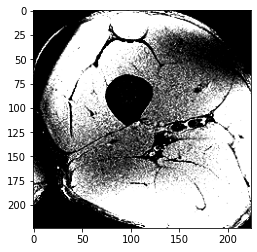

In [9]:
_vol_axial = vol_axial[0,0].permute(1, 2, 0)
plt.imshow(_vol_axial)
plt.show()

# Step 4: Model Declaration

In [10]:
class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

class TripleMRNet(nn.Module):

    __backbone__ = ['resnet18', 'alexnet']

    def __init__(self, backbone="resnet18", training=True):
        super().__init__()
        self.backbone = backbone

        # axial head
        if self.backbone == "resnet18":
            resnet = models.resnet18(pretrained=training)
            modules = list(resnet.children())[:-1]
            self.axial_net = nn.Sequential(*modules)
            for param in self.axial_net.parameters():
                param.requires_grad = False
        elif self.backbone == "alexnet":
            self.axial_net = models.alexnet(pretrained=training)

        # sagittal head
        if self.backbone == "resnet18":
            resnet = models.resnet18(pretrained=training)
            modules = list(resnet.children())[:-1]
            self.sagit_net = nn.Sequential(*modules)
            for param in self.sagit_net.parameters():
                param.requires_grad = False
        elif self.backbone == "alexnet":
            self.sagit_net = models.alexnet(pretrained=training)

        # coronal head
        if self.backbone == "resnet18":
            resnet = models.resnet18(pretrained=training)
            modules = list(resnet.children())[:-1]
            self.coron_net = nn.Sequential(*modules)
            for param in self.coron_net.parameters():
                param.requires_grad = False
        elif self.backbone == "alexnet":
            self.coron_net = models.alexnet(pretrained=training)

        self.gap_axial = nn.AdaptiveAvgPool2d(1)
        self.gap_sagit = nn.AdaptiveAvgPool2d(1)
        self.gap_coron = nn.AdaptiveAvgPool2d(1)
       
        if self.backbone == "resnet18":
            self.classifier = nn.Linear(3*512, 1)
        elif self.backbone == "alexnet":
            self.classifier = nn.Linear(3*256, 1)

    def forward(self, vol_axial, vol_sagit, vol_coron):
        vol_axial = torch.squeeze(vol_axial, dim=0)
        vol_sagit = torch.squeeze(vol_sagit, dim=0)
        vol_coron = torch.squeeze(vol_coron, dim=0)
       
        if self.backbone == "resnet18":
            vol_axial = self.axial_net(vol_axial)
            vol_sagit = self.sagit_net(vol_sagit)
            vol_coron = self.coron_net(vol_coron)
        elif self.backbone == "alexnet":
            vol_axial = self.axial_net.features(vol_axial)
            vol_sagit = self.sagit_net.features(vol_sagit)
            vol_coron = self.coron_net.features(vol_coron)

        vol_axial = self.gap_axial(vol_axial).view(vol_axial.size(0), -1)
        x = torch.max(vol_axial, 0, keepdim=True)[0]
        vol_sagit = self.gap_sagit(vol_sagit).view(vol_sagit.size(0), -1)
        y = torch.max(vol_sagit, 0, keepdim=True)[0]
        vol_coron = self.gap_coron(vol_coron).view(vol_coron.size(0), -1)
        z = torch.max(vol_coron, 0, keepdim=True)[0]

        w = torch.cat((x, y, z), 1)
        out = self.classifier(w)
        return out

# Step 5: Model Training

In [13]:
def run_model(model, loader, train=False, optimizer=None, abnormal_model_path=None):
    preds = []
    labels = []

    if train:
        model.train()
    else:
        if abnormal_model_path:
            abnormal_model = TripleMRNet(backbone=model.backbone)
            state_dict = torch.load(abnormal_model_path)
            abnormal_model.load_state_dict(state_dict)
            abnormal_model.cuda()
            abnormal_model.eval()
        model.eval()

    total_loss = 0.0
    num_batches = 0

    for batch in tqdm(loader):
        vol_axial, vol_sagit, vol_coron, label, abnormal = batch
        
        if train:
            if abnormal_model_path and not abnormal:
                continue
            optimizer.zero_grad()

        if loader.dataset.use_gpu:
            vol_axial, vol_sagit, vol_coron = vol_axial.cuda(), vol_sagit.cuda(), vol_coron.cuda()
            label = label.cuda()
        vol_axial, vol_sagit, vol_coron = Variable(vol_axial), Variable(vol_sagit), Variable(vol_coron)
        label = Variable(label)

        logit = model.forward(vol_axial, vol_sagit, vol_coron)

        loss = loader.dataset.weighted_loss(logit, label)
        total_loss += loss.item()

        pred = torch.sigmoid(logit)

        pred_npy = pred.data.cpu().numpy()[0][0]

        if abnormal_model_path and not train:
            abnormal_logit = abnormal_model.forward(
                    vol_axial,
                    vol_sagit,
                    vol_coron)
            abnormal_pred = torch.sigmoid(abnormal_logit)
            abnormal_pred_npy = abnormal_pred.data.cpu().numpy()[0][0]
            pred_npy = pred_npy * abnormal_pred_npy

        label_npy = label.data.cpu().numpy()[0][0]

        preds.append(pred_npy)
        labels.append(label_npy)

        if train:
            loss.backward()
            optimizer.step()
        num_batches += 1

    avg_loss = total_loss / num_batches
    
    fpr, tpr, threshold = metrics.roc_curve(labels, preds)
    auc = metrics.auc(fpr, tpr)

    if abnormal_model_path and not train:
        del abnormal_model

    return avg_loss, auc, preds, labels

In [40]:
def train(dirs, task, backbone, hyper_params, use_gpu, abnormal_model_path=None):
    rundir = dirs['rundir']
    train_dir = dirs['train_dir']
    valid_dir = dirs['valid_dir']
    
    epochs = hyper_params['epochs']
    learning_rate = hyper_params['learning_rate']
    weight_decay = hyper_params['weight_decay']
    max_patience = hyper_params['max_patience']
    factor = hyper_params['factor']

    train_loader, valid_loader = load_data(train_dir, valid_dir, task, use_gpu)
    
    model = TripleMRNet(backbone=backbone)
    max_epoch = None
    for dirpath, dirnames, files in os.walk(rundir):
        if not files:
            break
        max_epoch = 0
        model_path = None
        for fname in files:
            if fname.endswith(".json"):
                continue
            ep = int(fname[27:])
            if ep >= max_epoch:
                max_epoch = ep
                model_path = os.path.join(dirpath, fname)
        
        if model_path:
            state_dict = torch.load(model_path, map_location=(None if use_gpu else 'cpu'))
            model.load_state_dict(state_dict)

    if use_gpu:
        model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=max_patience, factor=factor, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    epoch = 0
    if max_epoch: 
        epoch += max_epoch
    while epoch < epochs:
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(
                model, train_loader, train=True, optimizer=optimizer,
                abnormal_model_path=abnormal_model_path)

        print(f'train loss: {train_loss:0.4f}')
        print(f'train AUC: {train_auc:0.4f}')

        val_loss, val_auc, _, _ = run_model(model, valid_loader,
                abnormal_model_path=abnormal_model_path)
        
        print(f'valid loss: {val_loss:0.4f}')
        print(f'valid AUC: {val_auc:0.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

            file_name = f'val{val_loss:0.4f}_train{train_loss:0.4f}_epoch{epoch+1}'
            save_path = Path(rundir) / file_name
            torch.save(model.state_dict(), save_path)

        epoch += 1

In [31]:
def create_dir(path):
    try: os.mkdir(path) 
    except: pass

In [46]:
GPU_ENABLE = True
RANDOM_SEED = 0

rundir_path = '/content/rundir'
create_dir(rundir_path)
dirs = {
    'rundir': rundir_path,
    'train_dir': '/content/MRNet-v1.0/train',
    'valid_dir': '/content/MRNet-v1.0/valid'
}

backbone = 'alexnet'
task = 'acl'
abnormal_model_path = None

hyper_params = {
    'epochs': 15,
    'learning_rate': 1e-05,
    'weight_decay': 0.01,
    'max_patience': 5,
    'factor': 0.3,
}

# set random seed
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if GPU_ENABLE:
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [48]:
train(dirs, task, backbone, hyper_params, use_gpu=GPU_ENABLE, abnormal_model_path=abnormal_model_path)

starting epoch 10. time passed: 0:00:00.000010


100%|██████████| 1130/1130 [02:32<00:00,  7.41it/s]


train loss: 0.1080
train AUC: 0.9425


100%|██████████| 120/120 [00:16<00:00,  7.33it/s]


valid loss: 0.2566
valid AUC: 0.9439
starting epoch 11. time passed: 0:02:50.140140


100%|██████████| 1130/1130 [02:29<00:00,  7.56it/s]


train loss: 0.1058
train AUC: 0.9479


100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


valid loss: 0.2081
valid AUC: 0.9377
starting epoch 12. time passed: 0:05:37.637751


100%|██████████| 1130/1130 [02:29<00:00,  7.58it/s]


train loss: 0.0993
train AUC: 0.9576


100%|██████████| 120/120 [00:16<00:00,  7.33it/s]


valid loss: 0.1863
valid AUC: 0.9450
starting epoch 13. time passed: 0:08:24.495912


100%|██████████| 1130/1130 [02:29<00:00,  7.58it/s]


train loss: 0.1007
train AUC: 0.9562


100%|██████████| 120/120 [00:16<00:00,  7.26it/s]


valid loss: 0.1687
valid AUC: 0.9442
starting epoch 14. time passed: 0:11:11.501231


100%|██████████| 1130/1130 [02:29<00:00,  7.56it/s]


train loss: 0.0969
train AUC: 0.9564


100%|██████████| 120/120 [00:16<00:00,  7.24it/s]


valid loss: 0.1627
valid AUC: 0.9529
starting epoch 15. time passed: 0:13:58.958570


100%|██████████| 1130/1130 [02:30<00:00,  7.53it/s]


train loss: 0.0981
train AUC: 0.9594


100%|██████████| 120/120 [00:16<00:00,  7.31it/s]

valid loss: 0.1821
valid AUC: 0.9537
